In [48]:
!ls

boolean_subset_structure.ipynb
classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
data = pd.read_csv("mhcld_puf_2021.csv")

In [51]:
NUM_POINTS = 50_000
data = data[:NUM_POINTS]

In [52]:
# Load data (deserialize)
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)

In [53]:
codebook_descriptions['DEPRESSFLG']

'Depressive disorder reported'

In [39]:
#disorder columns
#they are all 0/1 data
#these are dignoses for the disorders
#there are 13 of them
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [40]:
data[disorder_cols].value_counts()[0].head(16)

ANXIETYFLG  ADHDFLG  CONDUCTFLG  DELIRDEMFLG  BIPOLARFLG  DEPRESSFLG  ODDFLG  PDDFLG  SCHIZOFLG  PERSONFLG  ALCSUBFLG  OTHERDISFLG
0           0        0           0            0           1           0       0       0          0          0          0              9194
                                                          0           0       0       1          0          0          0              7142
            1        0           0            0           0           0       0       0          0          0          0              3856
            0        0           0            1           0           0       0       0          0          0          0              3702
1           0        0           0            0           1           0       0       0          0          0          0              3351
                                                          0           0       0       0          0          0          0              2728
0           0        0           0 

In [54]:
#generate labels using k-means
from sklearn.cluster import KMeans

In [55]:
#perform the elbow method
inertia = []
for k in range(3,20):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, n_init=10)
    kmeans.fit(data[disorder_cols])
    label_df = pd.DataFrame(kmeans.labels_,columns=['label'])
    inertia.append((k,kmeans.inertia_))

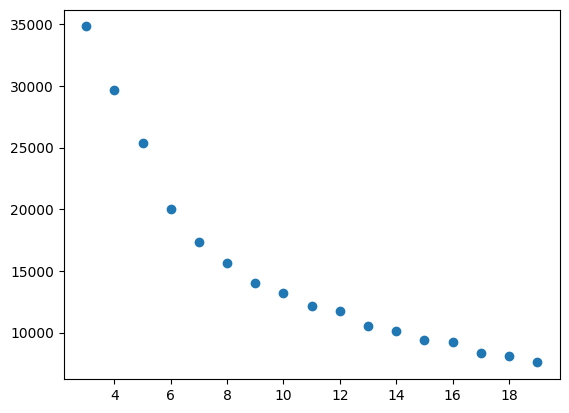

In [56]:
plt.scatter(np.array(inertia)[:,0],np.array(inertia)[:,1])
plt.show()

In [44]:
NUM_CLUSTERS_ELBOW = 10

In [57]:
#somewhere between 7-10
kmeans = KMeans(n_clusters=NUM_CLUSTERS_ELBOW, init='k-means++', max_iter=300, random_state=0, n_init=10)
kmeans.fit(data[disorder_cols])
label_df = pd.DataFrame(kmeans.labels_,columns=['label'])

In [18]:
#perform hierarchical agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
agg.fit(data[disorder_cols])
agg_label_df = pd.DataFrame(agg.labels_,columns=['label'])

KeyboardInterrupt: 

In [84]:
NUM_CLUSTERS_AGG = 10

In [21]:
#use DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=.1, min_samples=2, metric='euclidean')
db = db.fit(data[disorder_cols])
db_label_df = pd.DataFrame(db.labels_,columns=['label'])

KeyboardInterrupt: 

In [20]:
NUM_CLUSTERS_DB = len(set(db_label_df['label']))

In [19]:
codebook_descriptions['OTHERDISFLG']

'Other mental disorder reported'

In [20]:
db_label_df.value_counts()[:10]

NameError: name 'db_label_df' is not defined

In [71]:
db_label_df.value_counts().loc[19]/len(db_label_df)

label
19       0.01744
dtype: float64

In [70]:
data_labeled[data_labeled['label']==19].iloc[0]

label          19
TRAUSTREFLG     0
ANXIETYFLG      0
ADHDFLG         1
CONDUCTFLG      0
DELIRDEMFLG     0
BIPOLARFLG      0
DEPRESSFLG      0
ODDFLG          1
PDDFLG          0
SCHIZOFLG       0
PERSONFLG       0
ALCSUBFLG       0
OTHERDISFLG     0
Name: 28, dtype: int64

In [110]:
#meanshift
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth=.1)
ms.fit(data[disorder_cols])

MeanShift(bandwidth=0.1)

In [111]:
ms_label_df = pd.DataFrame(ms.labels_,columns=['label'])

In [112]:
ms_label_df.value_counts()

label
0        1829
1        1463
2         810
3         739
4         677
         ... 
134         1
135         1
136         1
138         1
159         1
Length: 160, dtype: int64

In [58]:
#perform t-SNE
from sklearn.manifold import TSNE

In [59]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)

In [24]:
tsne_results = tsne.fit_transform(data[disorder_cols])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.038s...
[t-SNE] Computed neighbors for 50000 samples in 10.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

In [60]:
tsne_df = pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

In [61]:
tsne_df.shape

(50000, 2)

In [62]:
tsne_results_labeled = label_df.merge(tsne_df, left_index=True, right_index=True)

In [29]:
data_labeled = label_df.merge(data[disorder_cols], left_index=True, right_index=True)

(-20.0, 20.0)

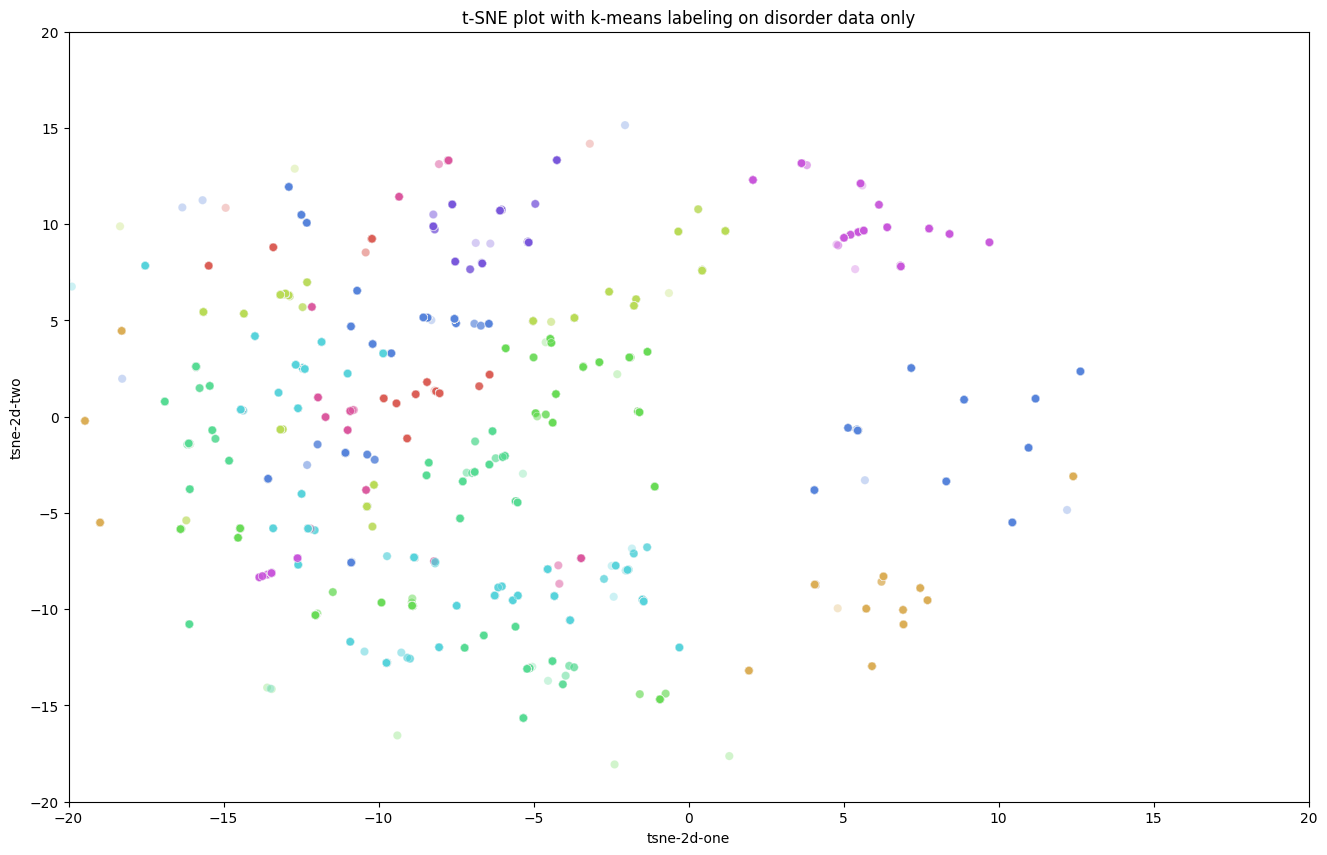

In [63]:
#plot the t-SNE results with diagnostic labels
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", NUM_CLUSTERS_ELBOW),
    data=tsne_results_labeled,
    legend=False,
    alpha=0.3
)
plot.set(title='t-SNE plot with k-means labeling on disorder data only')
plt.xlim(-20,20)
plt.ylim(-20,20)

In [72]:
#apply elbow method by keeping list kmeans.inertia_ and plotting
#can also try silhouette coefficient, sklearn.metrics.silhouette_score

In [99]:
fig = plot.get_figure()
fig.savefig("./plots/tsne-plot_db-scan_data-points=50k_disorder-data-only.png")

(50000, 4) (4, 13)


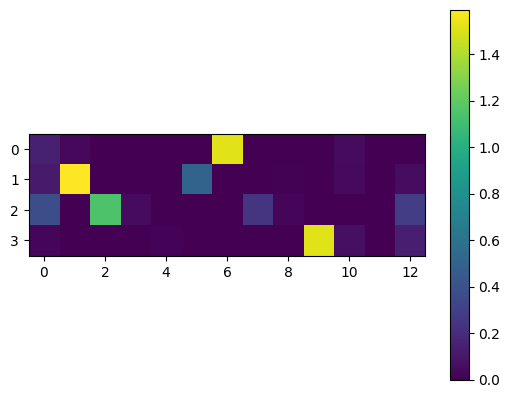

In [23]:
#perform non-negative matrix factorization
from sklearn.decomposition import NMF
nmf = NMF(n_components=4, init='random', random_state=0)
W=nmf.fit_transform(data[disorder_cols])
H=nmf.components_
print(W.shape, H.shape)
plt.imshow(H)
plt.colorbar()
plt.show()